This script is used to derive the tagger SF and uncertainty on the signal.

In [5]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

import json
import pickle as pkl
import warnings
from typing import List

import numpy as np
import scipy
from hist import Hist

def get_finetuned_score(data, model_path):
    import onnx
    import onnxruntime as ort

    input_dict = {
        "highlevel": data.loc[:, "fj_ParT_hidNeuron000":"fj_ParT_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["AzureExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]

In [6]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
! ls ../eos/

Aug19_hww_2017                  Oct10_hww_2016APV
Aug19_hww_2018                  Oct10_hww_2016APV_oldsignal
Aug19_triggerSF_alpha_2016      Oct10_hww_2016_oldsignal
Aug19_triggerSF_alpha_2016APV   Oct10_hww_2017
Aug19_triggerSF_alpha_2017      Oct10_hww_2017_oldsignal
Aug19_triggerSF_alpha_2018      Oct10_hww_2018
July18_hww_2016APV_BKGS         Oct10_hww_2018_oldsignal
July18_hww_2016_BKGS            Oct10_hww_signal_2016
July18_hww_2017_BKGS            Oct10_hww_signal_2016APV
July18_hww_2018_BKGS            Oct10_hww_signal_2017
July18_hww_uselooselep_2016     Oct10_hww_signal_2018
July18_hww_uselooselep_2016APV  Oct10_hww_uselooselep_2016
July18_hww_uselooselep_2017     Oct10_hww_uselooselep_2016APV
July18_hww_uselooselep_2018     Oct10_hww_uselooselep_2017
July1_eleisoSF_2017             Oct10_hww_uselooselep_2018
July23_triggerSF_2016           Oct16_LP_2017
July23_triggerSF_2016APV        Oct16_LP_2018
July23_triggerSF_2017           Oct2_hww_uselooselep_2016
July23_triggerSF_

In [146]:
 # define your regions here
presel = {
        "mu": {
            "lepmiso": "(lep_pt<55) | ( (lep_pt>=55) & (lep_misolation<0.8))",   # needed for the fakes            

#             "jetvetomap": "jetvetomap==1",
            "msoftdrop": "fj_mass>40",
#             "THWW": "THWW>0.75",
            "bveto": "n_bjets_T==0",
            
#             "ggF": "( ( (mjj<1000) | (deta<3.5) ) )",
            "VBF": "( (mjj>1000) & (deta>3.5) )",
        },
        "ele": {

#             "jetvetomap": "jetvetomap==1",            
            "msoftdrop": "fj_mass>40",
#             "THWW": "THWW>0.75",
            "bveto": "n_bjets_T==0",
            
#             "ggF": "( ( (mjj<1000) | (deta<3.5) ) )",
            "VBF": "( (mjj>1000) & (deta>3.5) )",            
        },
}

if "ggF" in presel["mu"]:
    cat = "ggF"
else:
    cat = "VBF"

samples = [
    "ggF",
    "VBF",
    "WH",
    "ZH",
    "ttH",
]

channels = [
    "ele",
    "mu",
]

years = [
#     "2016",
#     "2016APV",
    "2017",
    "2018",
]



In [147]:
events_dict = {}

In [148]:
samples_dir = {
    "2016":    "../eos/Oct16_LP_2016",
    "2016APV": "../eos/Oct16_LP_2016APV",
    "2017":    "../eos/Oct16_LP_2017",
    "2018":    "../eos/Oct16_LP_2018",
}

THWW_path = "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx"

sys.path.append("../python")
from make_stacked_hists import make_events_dict

events_dict = make_events_dict(years, channels, samples_dir, samples, presel, THWW_path)

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:Applying msoftdrop selection on 1717 events
INFO:root:Applying bveto selection on 1472 events
INFO:root:Applying VBF selection on 1447 events
INFO:root:Will fill the VBF dataframe with the remaining 649 events
INFO:root:tot event weight 6.08151301350172 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:Applying msoftdrop selection on 4025 events
INFO:root:Applying bveto selection on 3404 events
INFO:root:Applying VBF selection on 3294 events
INFO:root:Will fill the WH dataframe with the remaining 66 events
INFO:root:tot event weight 0.04017660188058992 

INFO:root:Finding GluGluHToWWToLNuQQ_M-125_TuneCP5_13TeV_powheg_jhugen751_pythia8 samples and should combine them under ggF
INFO:root:Applying msoftdrop selection on 1 events
INFO:root:Applying bveto selection on 1 events
INFO:root:Applying VBF selection on 1 events
INFO:root:Will 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:Applying lepmiso selection on 7423 events
INFO:root:Applying msoftdrop selection on 7423 events
INFO:root:Applying bveto selection on 6172 events
INFO:root:Applying VBF selection on 5982 events
INFO:root:Will fill the WH dataframe with the remaining 133 events
INFO:root:tot event weight 0.09734510774251665 

INFO:root:Finding GluGluHToWWToLNuQQ_M-125_TuneCP5_13TeV_powheg_jhugen751_pythia8 samples and should combine them under ggF
INFO:root:Applying lepmiso selection on 2 events
INFO:root:Applying msoftdrop selection on 2 events
INFO:root:Applying bveto selection on 1 events
INFO:root:Applying VBF selection on 1 events
INFO:root:Will fill the ggF dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under ggF
INFO:root:Applying lepmiso selection on 7238 events
INFO:root:Applying msoftdrop selection on 7

In [149]:
channels_to_combine = [
    "ele",
    "mu",
]

years_to_combine = [
#     "2016",
#     "2016APV",
    "2017",
    "2018",
]

df_combined = []
for year in years_to_combine:
    for ch in channels_to_combine:
        print(year, ch)
        for sig in samples:
            df_combined.append(events_dict[year][ch][sig])

df_combined = pd.concat(df_combined)

2017 ele
2017 mu
2018 ele
2018 mu


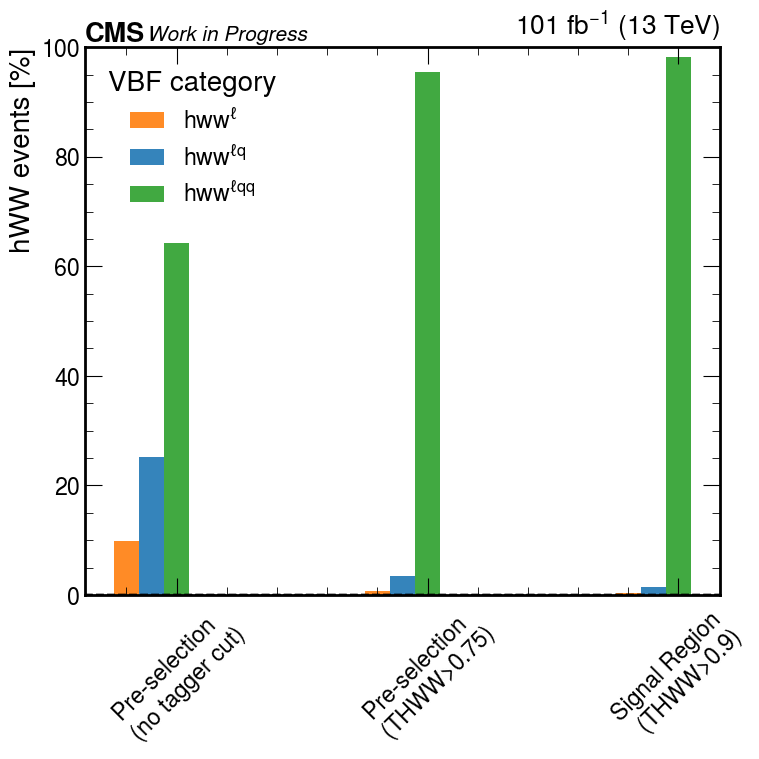

In [150]:
############################################# Config
%matplotlib inline
plt.rcParams.update({"font.size": 20})

# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

color_by_sample = {
    0: "tab:orange", 
    1: "tab:blue",
    2: "tab:green",
}

regions = {
    "Pre-selection \n (no tagger cut)": 0,
    "Pre-selection \n (THWW>0.75)": 0.75,
    "Signal Region \n (THWW>0.9)": 0.9,
}
#############################################

is_hww_l = (df_combined["num_m_quarks"]==0)
is_hww_lq = (df_combined["num_m_quarks"]==1)
is_hww_lqq = (df_combined["num_m_quarks"]==2)

num_topologies = 3
bar_width = 0.1

fig, ax = plt.subplots(figsize=(8, 8))

for iregion, (region, cut) in enumerate(regions.items()):

    for i, (key, var) in enumerate(
        {
            r"$hww^{\ell}$": is_hww_l,
            r"$hww^{{\ell}q}$": is_hww_lq,
            r"$hww^{{\ell}qq}$": is_hww_lqq,
        }.items()
    ):

        X = 100 * (var & (df_combined["THWW"]>cut)).sum() / sum(df_combined["THWW"]>cut)
        bars = ax.bar(
            iregion + i * bar_width, 
            X, 
            bar_width, 
            color=color_by_sample[i],
            label=key,
            alpha=0.9,
        )
        ax.axhline(y=0, color='black', linestyle='--')

# Customize ticks and labels
#     ax.set_yticks(np.arange(-2, 3, 1))
# ax.set_ylim(-2.5, 2.5)

# Adjust the number of x-tick labels to match the number of groups
plt.xticks(np.arange(len(regions)) + bar_width * 2, regions, rotation=45)

# Add a legend
handles, labels = ax.get_legend_handles_labels()[0][:num_topologies], ax.get_legend_handles_labels()[1][:num_topologies]
ax.legend(handles, labels, loc='upper left', title=f"{cat} category")

ax.set_ylabel("hWW events [%]")
ax.set_ylim(0,100)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/LP_mquarks_{cat}.pdf")    

In [138]:
for key in df:
    if "is" in key:
        print(key)

lep_isolation
lep_misolation
loose_lep1_miso
fj_H_VV_isVlepton
fj_H_VV_isVstarlepton
fj_H_VV_isMatched
fj_isggF
weight_mu_trigger_iso_muonUp
weight_mu_isolation_muonDown
weight_mu_trigger_noniso_muonUp
weight_mu_trigger_noniso_muonDown
weight_mu_isolation_muonUp
weight_mu_trigger_iso_muonDown
LP_weight_distortion_up
LP_weight_distortion_down


In [139]:
# import vector 
# # Create 4-vectors from px, py, pz, and energy
# vec = vector.array({
#     "px": pxs,
#     "py": pys,
#     "pz": pzs,
#     "E": Es
# })

# # Now you can access pt, eta, phi, and energy components
# pts = vec.pt
# etas = vec.eta
# phis = vec.phi
# energies = vec.E  # Energy remains unchanged

# # Stack these new vectors back into a new array
# new_pf_cands = np.stack([pts, etas, phis, energies], axis=-1)

## Retrieve the pfcands, genquark, and ak8 jet info

In [151]:
########### combine all signal under one key

samples_to_combine = [
    "ggF",
    "VBF",
    "WH",
    "ZH",
    "ttH",    
]

for year in years:
    for ch in channels:
        
        df = []
        for sig in samples_to_combine:
            df.append(events_dict[year][ch][sig])        
        events_dict[year][ch]["sig"] = pd.concat(df)

In [152]:
for year in years:
    for ch in channels:
        
        df = events_dict[year][ch]["sig"]
        
        is_hww_l = (df["num_m_quarks"]==0)
        is_hww_lq = (df["num_m_quarks"]==1)
        is_hww_lqq = (df["num_m_quarks"]==2)

        msk = is_hww_lqq
        df = df[msk]  
        
        # (1) PFcands
        pxs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("px")].values
        pys = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("py")].values
        pzs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("pz")].values
        Es = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("energy")].values

        pf_cands = np.stack([pxs,pys,pzs,Es], axis=-1)

        # (2) ak8 jet, and the THWW score
        ak8_jets = np.stack([df["LP_fj_pt"].values, df["LP_fj_eta"].values, df["LP_fj_phi"].values, df["LP_fj_mass"].values], axis=-1)

        # (3) genQuarks
        etas = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("eta")].values
        phis = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("phi")].values

        gen_parts_eta_phi = np.stack([etas,phis], axis=-1)     
        
        ############## RUN LPR
        #use small number of events for the example, but generally advisable to use larger sample
        max_evts = 10000000_000

        import sys, os
        sys.path.insert(0, '')
        sys.path.append("LundReweighting")
        from LundReweighting.utils.Utils import *

        """ An example how to use the Lund Plane reweighting  code. 
        Computes reweighting factors for an example signal. 
        Uses them to compute the efficiency and uncertainty of a given substructure cut"""

        ######################## Setup 

        #Input file 
        fname = "LundReweighting/data/example_signal.h5"
        f_ratio_name = f'LundReweighting/data/ratio_{year}.root'

        f_sig = h5py.File(fname, "r")
        f_ratio = ROOT.TFile.Open(f_ratio_name)

        #Class to help read input dataset 
        d = Dataset(f_sig, dtype = 1)
        d.compute_obs()

        #Main class for reweighting utilities
        LP_rw = LundReweighter(f_ratio = f_ratio)

        ################### Compute reweighting factors

        #PF candidates in the AK8 jet for each event (list of (px,py,pz,E))
        pf_cands = pf_cands[:max_evts]
        print("Running on %i events" % len(pf_cands))

        #Generator level quarks from hard process 
        gen_parts_eta_phi = gen_parts_eta_phi[:max_evts]

        #4 vector of AK8 jets we are calibrating
        ak8_jets = ak8_jets[:max_evts]

        #Nominal event weights of the MC, (assume every event is weight '1' for this example)
        nom_weights = np.ones(len(pf_cands))

        #Compute reweighting factors and all systematic variations
        LP_weights = LP_rw.get_all_weights(pf_cands, gen_parts_eta_phi, ak8_jets)

        #multiply Lund plane weights with nominal event weights
        for key in LP_weights.keys():
            if('nom' in key or 'up' in key or 'down' in key):
                if(isinstance(LP_weights[key], np.ndarray)) : LP_weights[key] *= nom_weights

        #Fraction of prongs that are not well matched to subjets (want this to be low)
        print("Bad match frac %.2f" % np.mean(LP_weights['bad_match']))
        #Fraction of prongs that are still not well matched after reclustering with varied number of prongs
        print("Reclustered bad match frac %.2f" % np.mean(LP_weights['reclust_still_bad_match']))
        
        ############ store the LP weights as additional columns
        events_dict[year][ch]["sig"]["LP_weight_nom"] = 1
        events_dict[year][ch]["sig"]["LP_weight_nom"][msk] = LP_weights["nom"]

        sys_keys = ['sys', 'prongs', 'unclust', 'distortion']
        
        for sys_key in sys_keys:
            for variation in ["up", "down"]:
                key = sys_key + "_" + variation

                events_dict[year][ch]["sig"][f"LP_weight_{key}"] = 1
                events_dict[year][ch]["sig"][f"LP_weight_{key}"][msk] = LP_weights[key]
        events_dict[year][ch]["sig"].to_parquet(f"LP_sig_{year}_{ch}.parquet")
#         break
#     break
#         print("------------------------------")        

Running on 795 events
Only 795 jets given, will not include LP distortion systematic
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet

/Users/fmokhtar/projects/boostedhiggs/LP/LundReweighting/utils/LundReweighter.py:1021: RuntimeWarning: invalid value encountered in divide
  else: weights /= np.mean(weights)
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_48983/2980192991.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch]["sig"]["LP_weight_nom"] = 1
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_48983/2980192991.py:88: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the in

Bad match frac 0.24
Reclustered bad match frac 0.17
Running on 1165 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_48983/2980192991.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch]["sig"]["LP_weight_nom"] = 1
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_48983/2980192991.py:88: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_index

Running on 724 events
Only 724 jets given, will not include LP distortion systematic
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster


/Users/fmokhtar/projects/boostedhiggs/LP/LundReweighting/utils/LundReweighter.py:1021: RuntimeWarning: invalid value encountered in divide
  else: weights /= np.mean(weights)
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_48983/2980192991.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch]["sig"]["LP_weight_nom"] = 1
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_48983/2980192991.py:88: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the in

Bad match frac 0.22
Reclustered bad match frac 0.17
Running on 1167 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Bad match frac 0.17
Reclustered bad match frac 0.13


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_48983/2980192991.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  events_dict[year][ch]["sig"]["LP_weight_nom"] = 1
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_48983/2980192991.py:88: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_index

In [181]:
l = []
for year in years:
    for ch in channels:
        l.append(events_dict[year][ch]["sig"])
df = pd.concat(l)

is_hww_l = (df["num_m_quarks"]==0)
is_hww_lq = (df["num_m_quarks"]==1)
is_hww_lqq = (df["num_m_quarks"]==2)

msk = is_hww_lqq
df = df[msk]  

# (1) PFcands
pxs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("px")].values
pys = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("py")].values
pzs = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("pz")].values
Es = df.loc[:,df.columns.str.contains("LP_pfcand") & df.columns.str.contains("energy")].values

pf_cands = np.stack([pxs,pys,pzs,Es], axis=-1)

# (2) ak8 jet, and the THWW score
ak8_jets = np.stack([df["LP_fj_pt"].values, df["LP_fj_eta"].values, df["LP_fj_phi"].values, df["LP_fj_mass"].values], axis=-1)

# (3) genQuarks
etas = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("eta")].values
phis = df.loc[:,df.columns.str.contains("LP_quark") & df.columns.str.contains("phi")].values

gen_parts_eta_phi = np.stack([etas,phis], axis=-1)     

############## RUN LPR
#use small number of events for the example, but generally advisable to use larger sample
max_evts = 10000000_000

import sys, os
sys.path.insert(0, '')
sys.path.append("LundReweighting")
from LundReweighting.utils.Utils import *

""" An example how to use the Lund Plane reweighting  code. 
Computes reweighting factors for an example signal. 
Uses them to compute the efficiency and uncertainty of a given substructure cut"""

######################## Setup 

#Input file 
fname = "LundReweighting/data/example_signal.h5"
f_ratio_name = f'LundReweighting/data/ratio_{year}.root'

f_sig = h5py.File(fname, "r")
f_ratio = ROOT.TFile.Open(f_ratio_name)

#Class to help read input dataset 
d = Dataset(f_sig, dtype = 1)
d.compute_obs()

#Main class for reweighting utilities
LP_rw = LundReweighter(f_ratio = f_ratio)

################### Compute reweighting factors

#PF candidates in the AK8 jet for each event (list of (px,py,pz,E))
pf_cands = pf_cands[:max_evts]
print("Running on %i events" % len(pf_cands))

#Generator level quarks from hard process 
gen_parts_eta_phi = gen_parts_eta_phi[:max_evts]

#4 vector of AK8 jets we are calibrating
ak8_jets = ak8_jets[:max_evts]

#Nominal event weights of the MC, (assume every event is weight '1' for this example)
nom_weights = np.ones(len(pf_cands))

#Compute reweighting factors and all systematic variations
LP_weights = LP_rw.get_all_weights(pf_cands, gen_parts_eta_phi, ak8_jets)

#multiply Lund plane weights with nominal event weights
for key in LP_weights.keys():
    if('nom' in key or 'up' in key or 'down' in key):
        if(isinstance(LP_weights[key], np.ndarray)) : LP_weights[key] *= nom_weights

#Fraction of prongs that are not well matched to subjets (want this to be low)
print("Bad match frac %.2f" % np.mean(LP_weights['bad_match']))
#Fraction of prongs that are still not well matched after reclustering with varied number of prongs
print("Reclustered bad match frac %.2f" % np.mean(LP_weights['reclust_still_bad_match']))

############ store the LP weights as additional columns
df["LP_weight_nom"] = 1
df["LP_weight_nom"][msk] = LP_weights["nom"]

sys_keys = ['sys', 'prongs', 'unclust', 'distortion']

for sys_key in sys_keys:
    for variation in ["up", "down"]:
        key = sys_key + "_" + variation

        df[f"LP_weight_{key}"] = 1
        df[f"LP_weight_{key}"][msk] = LP_weights[key]

# #statistical and pt extrapolation uncertainties derived from 100 variations of the weights 
# #take std dev to determine unc

# nToys = LP_weights['stat_vars'].shape[1]
# eff_toys = []
# pt_eff_toys = []
# for i in range(nToys):
#     eff = np.average(score_cut, weights = LP_weights['stat_vars'][:,i])
#     eff_toys.append(eff)

#     eff1 = np.average(score_cut, weights = LP_weights['pt_vars'][:,i])
#     pt_eff_toys.append(eff1)

# #Compute stat and pt uncertainty based on variation in the toys
# toys_std = np.std(eff_toys)
# pt_toys_std = np.std(pt_eff_toys)

# df["LP_weight_stat_up"] = df["LP_weight_nom"] + toys_std
# df["LP_weight_stat_down"] = df["LP_weight_nom"] - toys_std

# df["LP_weight_pt_up"] = df["LP_weight_nom"] + pt_toys_std
# df["LP_weight_pt_down"] = df["LP_weight_nom"] - pt_toys_std

#         print("------------------------------")        

Running on 3851 events
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with zero quarks inside? Not attempting to recluster
Jet with

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_48983/4251077201.py:90: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["LP_weight_nom"][msk] = LP_weights["nom"]


ValueError: Array conditional must be same shape as self

In [178]:
(df[f"LP_weight_distortion_up"].isnull()).sum()

1110

In [179]:
len(df[f"LP_weight_distortion_up"])

2908

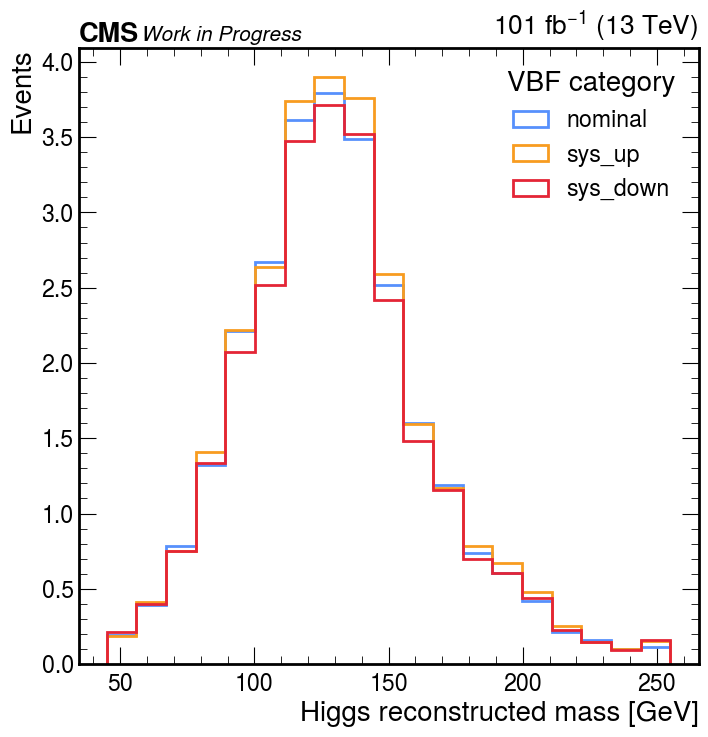

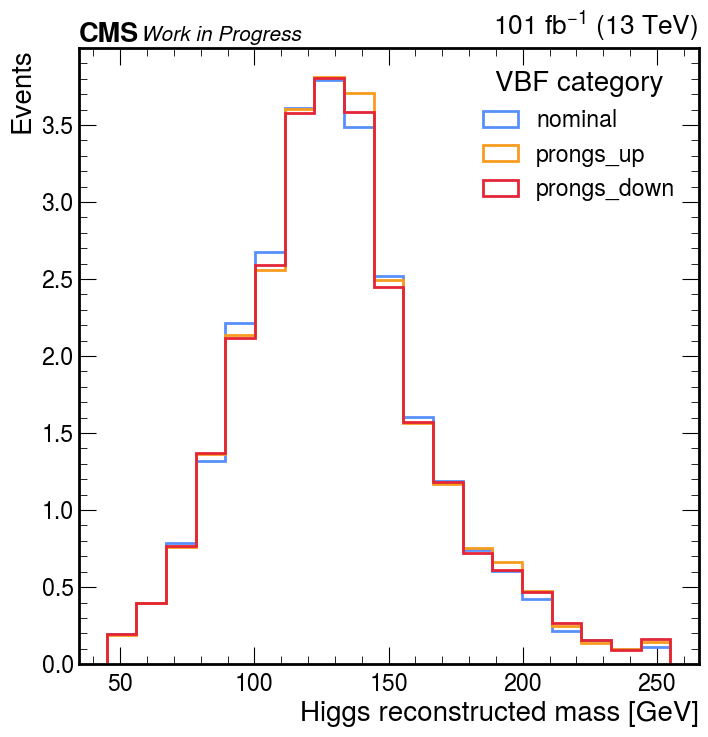

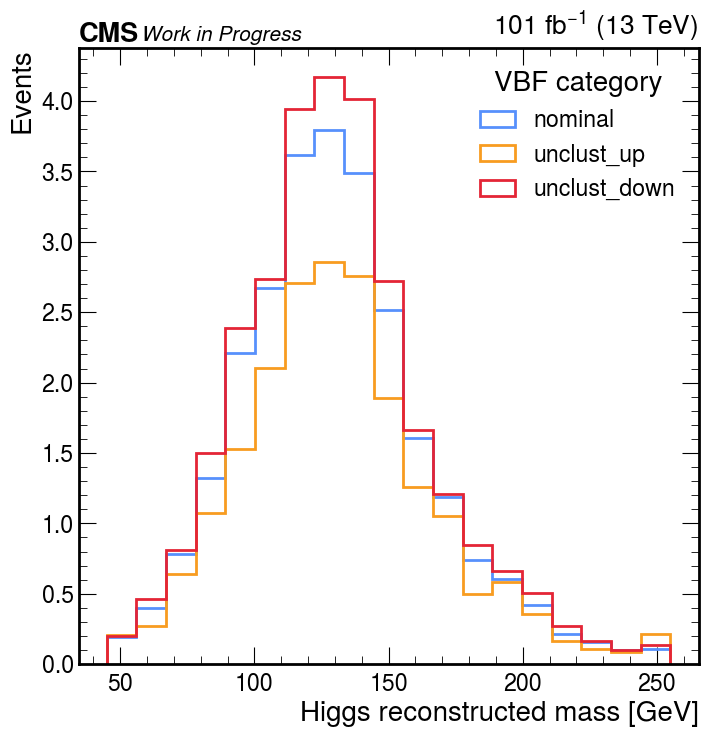

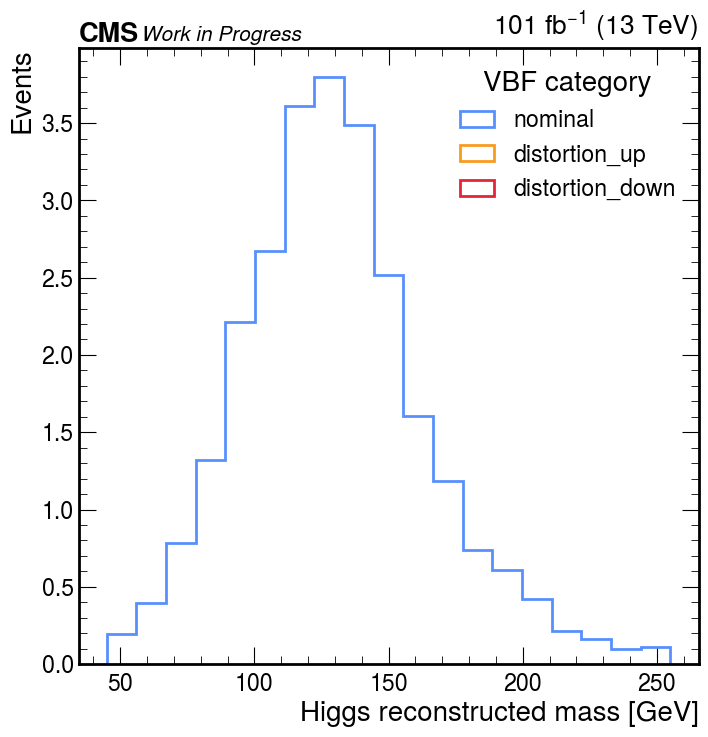

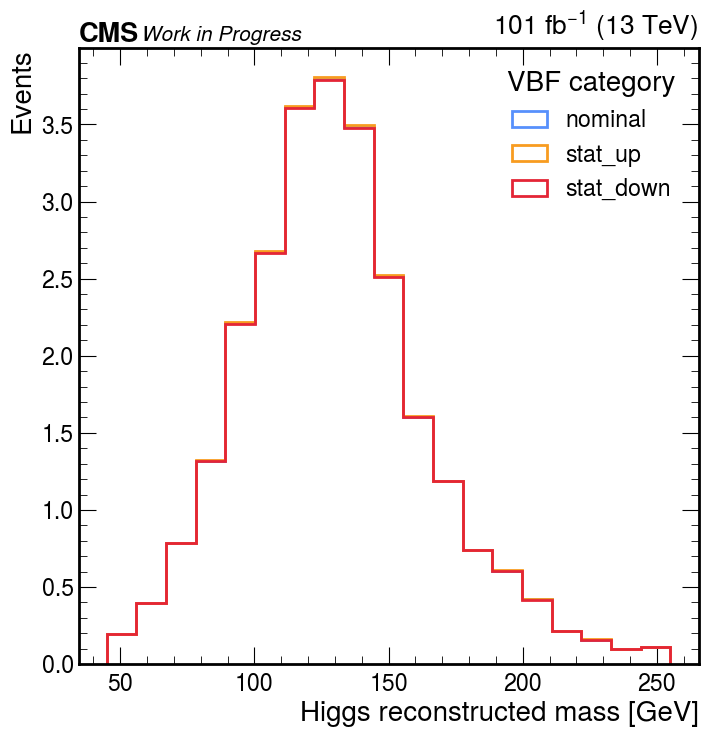

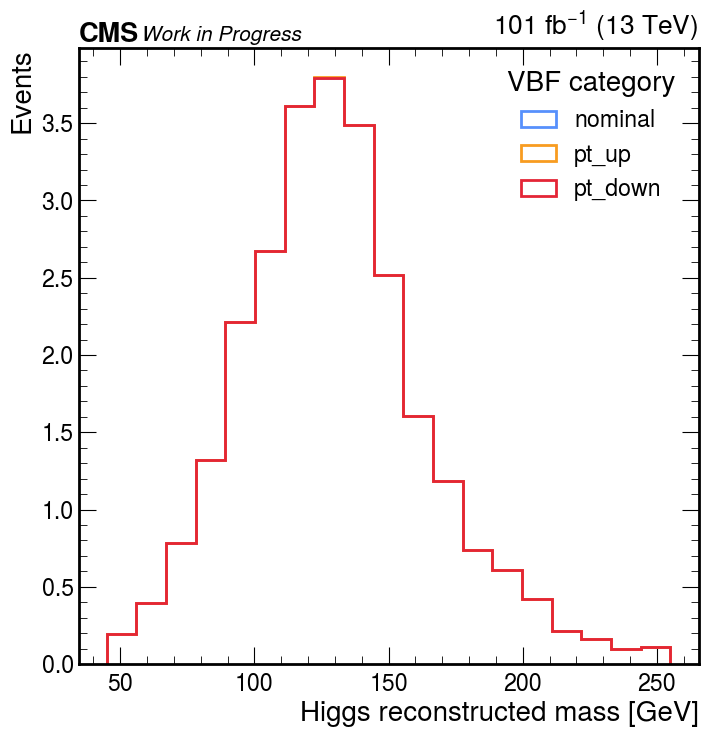

In [172]:
%matplotlib inline
plt.rcParams.update({"font.size": 20})

msk = df["THWW"]>0.5
df = df[msk]

#########################
sys_keys = ['sys', 'prongs', 'unclust', 'distortion', 'stat', 'pt']
for sys_key in sys_keys:
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    ax.hist(
        df["rec_higgs_m"],
        weights=df["nominal"] * df["LP_weight_nom"],
        bins=np.linspace(45, 255, 20),
        label="nominal",
        linewidth=2,
        histtype="step",
    )
    
    for variation in ["up", "down"]:
        key = sys_key + "_" + variation

        ax.hist(
            df["rec_higgs_m"],
            weights=df["nominal"] * df[f"LP_weight_{key}"],
            bins=np.linspace(45, 255, 20),
            label=key,
            linewidth=2,
            histtype="step",
        )

    ax.legend(title=f"{cat} category")

    ax.set_xlabel("Higgs reconstructed mass [GeV]")
    ax.set_ylabel("Events")

    hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

    plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/1dhist_sig_{cat}_{sys_key}.pdf")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'),
 supptext: Custom Text(1.012, 1, ''))

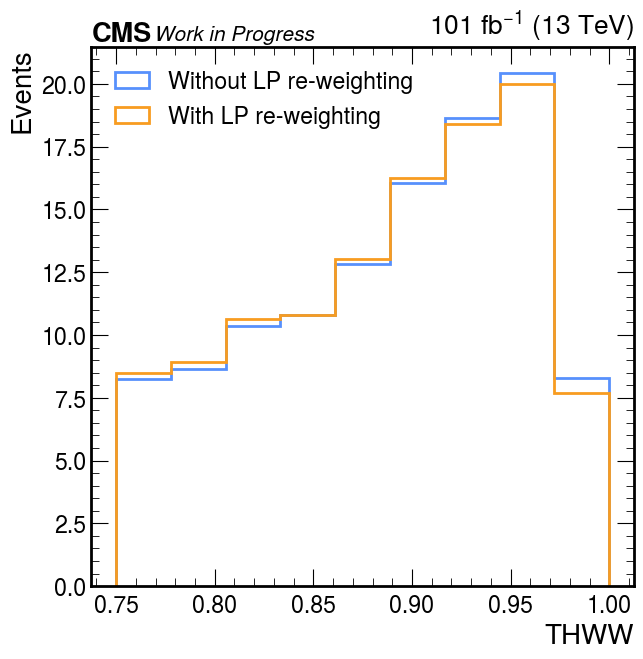

In [70]:
%matplotlib inline
plt.rcParams.update({"font.size": 20})

df = []
for year in years:
    for ch in channels:
        df.append(events_dict[year][ch]["sig"])
#         break
#     break
df = pd.concat(df)

fig, ax = plt.subplots(figsize=(7,7))

ax.hist(
    df["THWW"],
    weights=df["nominal"],
    bins=np.linspace(0.75, 1, 10),
    label="Without LP re-weighting",
    linewidth=2,
    histtype="step",
)
ax.hist(
    df["THWW"],
    weights=df["nominal"] * df["LP_weight_nom"],
    bins=np.linspace(0.75, 1, 10),
    label="With LP re-weighting",
    linewidth=2,
    histtype="step",
)

ax.legend()        

ax.set_xlabel("THWW")
ax.set_ylabel("Events")

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

# plt.savefig("/Users/fmokhtar/Desktop/AN_2024/mjj_preselection.pdf")

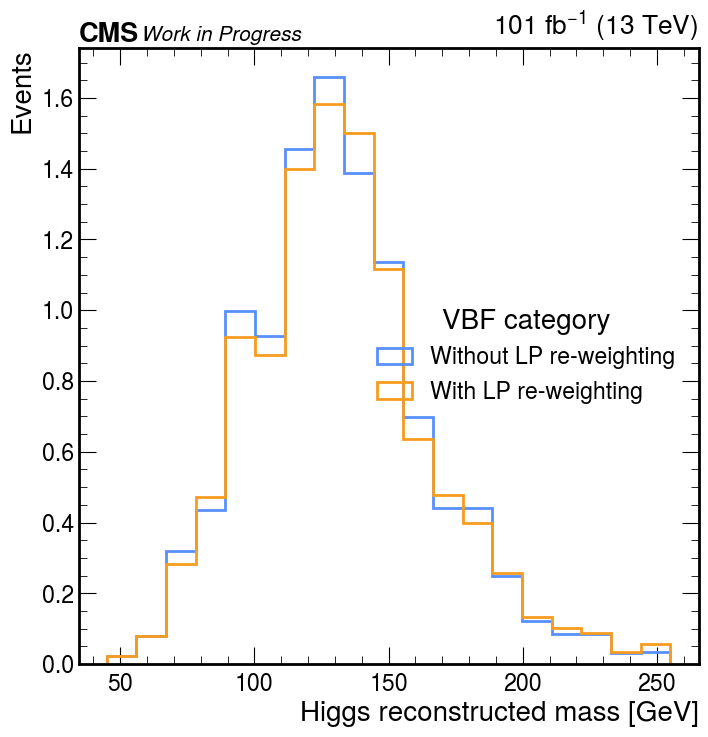

In [121]:
%matplotlib inline
plt.rcParams.update({"font.size": 20})

df = []
for year in years:
    for ch in channels:
        df.append(events_dict[year][ch]["sig"])
#         break
#     break
df = pd.concat(df)

msk = df["THWW"]>0.905
df = df[msk]

fig, ax = plt.subplots(figsize=(8,8))

ax.hist(
    df["rec_higgs_m"],
    weights=df["nominal"],
    bins=np.linspace(45, 255, 20),
    label="Without LP re-weighting",
    linewidth=2,
    histtype="step",
)
ax.hist(
    df["rec_higgs_m"],
    weights=df["nominal"] * df["LP_weight_nom"],
    bins=np.linspace(45, 255, 20),
    label="With LP re-weighting",
    linewidth=2,
    histtype="step",
)

ax.legend(title=f"{cat} category")

ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("Events")

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/1dhist_sig_{cat}.pdf")

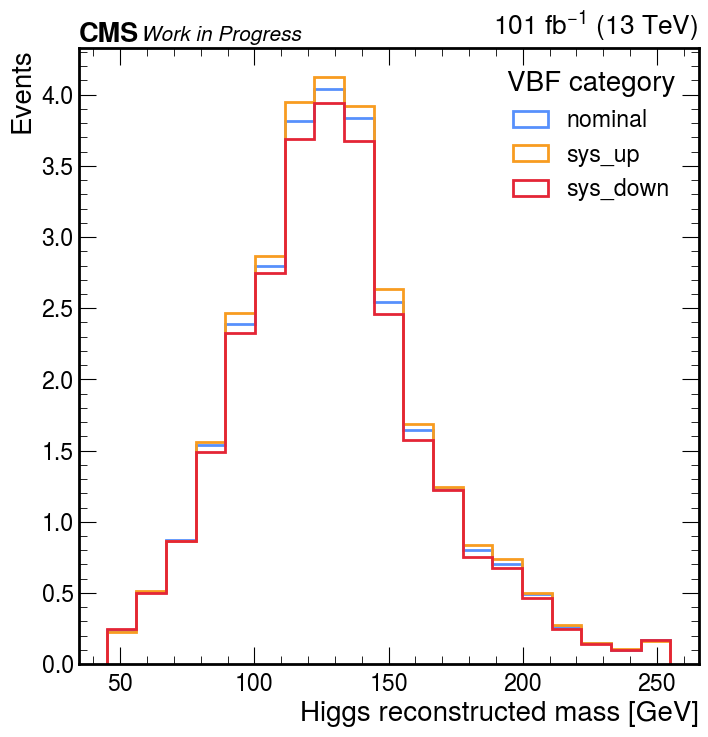

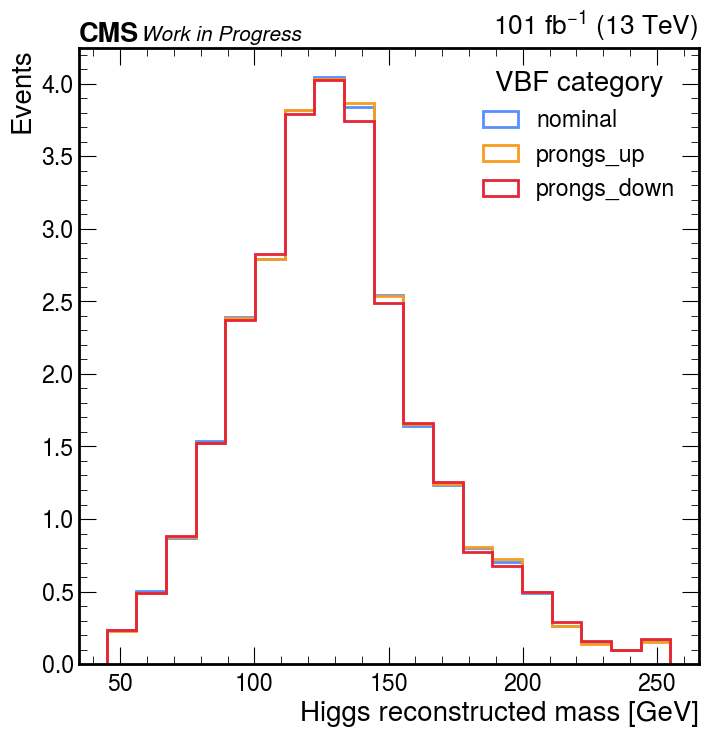

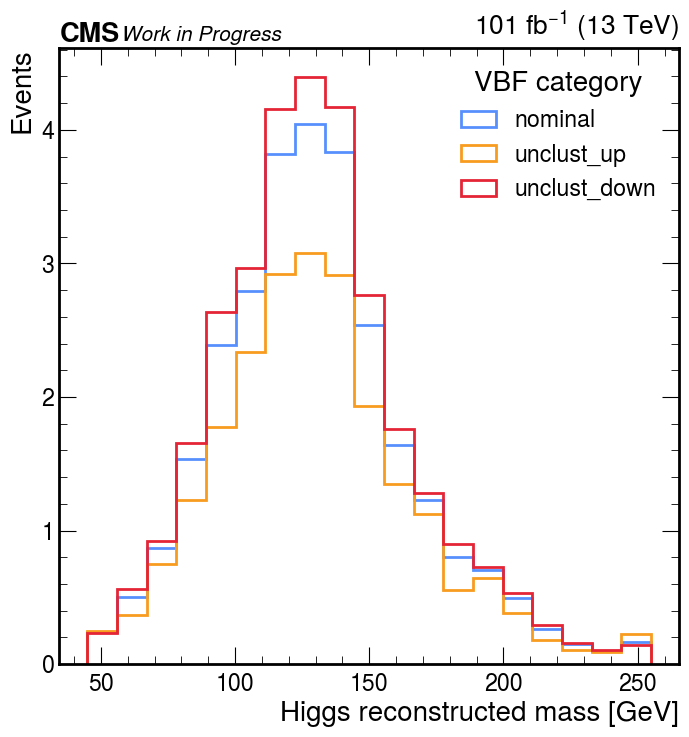

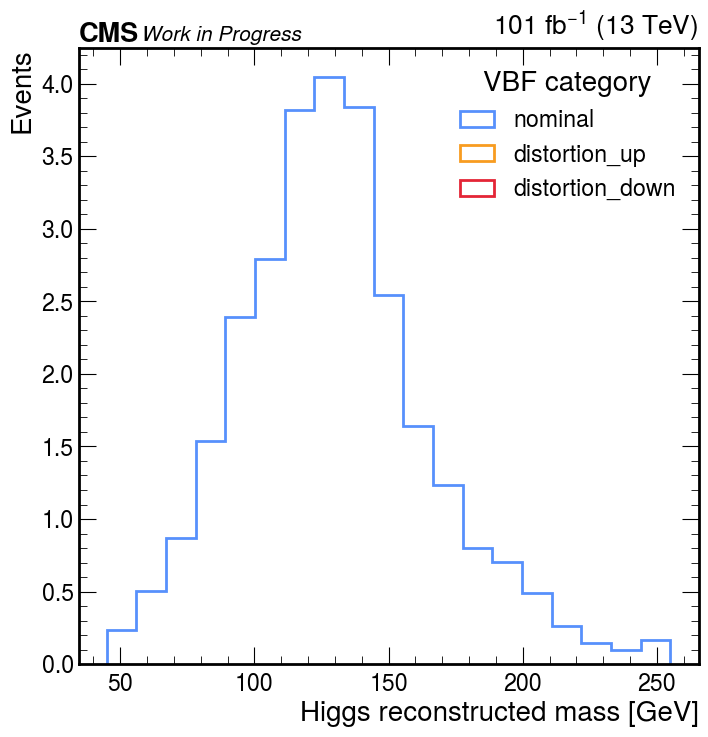

In [156]:
%matplotlib inline
plt.rcParams.update({"font.size": 20})

df = []
for year in years:
    for ch in channels:
        df.append(events_dict[year][ch]["sig"])
#         break
#     break
df = pd.concat(df)

msk = df["THWW"]>0.5
df = df[msk]

#########################
sys_keys = ['sys', 'prongs', 'unclust', 'distortion']
for sys_key in sys_keys:
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    ax.hist(
        df["rec_higgs_m"],
        weights=df["nominal"] * df["LP_weight_nom"],
        bins=np.linspace(45, 255, 20),
        label="nominal",
        linewidth=2,
        histtype="step",
    )
    
    for variation in ["up", "down"]:
        key = sys_key + "_" + variation

        ax.hist(
            df["rec_higgs_m"],
            weights=df["nominal"] * df[f"LP_weight_{key}"],
            bins=np.linspace(45, 255, 20),
            label=key,
            linewidth=2,
            histtype="step",
        )

    ax.legend(title=f"{cat} category")

    ax.set_xlabel("Higgs reconstructed mass [GeV]")
    ax.set_ylabel("Events")

    hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

    plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/LP/1dhist_sig_{cat}_{sys_key}.pdf")

In [157]:
df[f"LP_weight_distortion_up"]

124          NaN
258          NaN
272          NaN
280          NaN
281          NaN
          ...   
2734    1.000000
2873    0.849857
3985    1.000000
4675    1.000000
5193    1.000000
Name: LP_weight_distortion_up, Length: 3201, dtype: float64

In [131]:
df[f"LP_weight_sys_up"]

272      1.461740
309      0.891303
391      4.202998
662      0.642389
697      1.000000
           ...   
11536    1.094904
1034     1.000000
2873     0.677175
3985     1.000000
5193     1.000000
Name: LP_weight_sys_up, Length: 1187, dtype: float64

In [55]:
LP_weights["nom"]

array([0.87021579, 1.2956508 , 0.99473214, ..., 1.        , 1.        ,
       1.        ])

In [163]:
cut_dict = {
    "VBF category": 0.9105,
    "ggF category": 0.93,
}

for region, score_thresh in cut_dict.items():
    print(region)
#     score_thresh = 0.905

    score = df["THWW"].values[:max_evts]
    score_cut = score > score_thresh

    ###### Use weights to compute efficiency of a cut

    #Efficiency of the cut in nominal MC
    eff_nom = np.average(score_cut, weights = nom_weights)

    #Efficiency of the cut after the Lund Plane reweighting
    eff_rw = np.average(score_cut, weights = LP_weights['nom'])

    #Nominal 'scale factor'
    SF = eff_rw / eff_nom

    print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

    #NOTE, because there is kinematic dependence to the correction, it is better to use corrected efficiency computed 
    #separately for each MC sample rather than a single 'SF'


    ######  Compute uncertainties on the efficiency from the various weight variations ##############

    #statistical and pt extrapolation uncertainties derived from 100 variations of the weights 
    #take std dev to determine unc

    nToys = LP_weights['stat_vars'].shape[1]
    eff_toys = []
    pt_eff_toys = []
    for i in range(nToys):
        eff = np.average(score_cut, weights = LP_weights['stat_vars'][:,i])
        eff_toys.append(eff)

        eff1 = np.average(score_cut, weights = LP_weights['pt_vars'][:,i])
        pt_eff_toys.append(eff1)

    #Compute stat and pt uncertainty based on variation in the toys
    toys_mean = np.mean(eff_toys)
    toys_std = np.std(eff_toys)
    pt_toys_mean = np.mean(pt_eff_toys)
    pt_toys_std = np.std(pt_eff_toys)

    #if mean of toys is biased, also include it as an unc (should be zero)
    eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
    eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

    print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
    print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))

    #Other systematics come from up/down variations of the weights
    sys_keys = ['sys', 'bquark', 'prongs', 'unclust', 'distortion']
    sys_uncs = dict()

    for sys in sys_keys: sys_uncs[sys] = [0.,0.]

    #Compute difference in efficiency due to weight variations as uncertainty
    def get_uncs(cut, weights_up, weights_down, eff_baseline):
        eff_up =  np.average(cut, weights = weights_up)
        eff_down =  np.average(cut, weights = weights_down)

        unc_up = eff_up - eff_baseline
        unc_down = eff_down - eff_baseline 
        return unc_up, unc_down

    for sys in sys_keys:
        unc_up, unc_down = get_uncs(score_cut, LP_weights[sys + '_up'], LP_weights[sys + '_down'], eff_rw)
        sys_uncs[sys] = [unc_up, unc_down]


    #Print uncertainty breakdown
    eff_str = "Calibrated efficiency  is %.5f +/- %.5f (stat) +/- %.5f (pt)" % (eff_rw, eff_stat_unc, eff_pt_unc )
    tot_unc_up = tot_unc_down = eff_stat_unc**2 + eff_pt_unc**2

    for sys in sys_keys:
        eff_str += " %.5f/%.5f (%s)" % (sys_uncs[sys][0], sys_uncs[sys][1], sys)
        up_var = max(sys_uncs[sys][0], sys_uncs[sys][1])
        down_var = min(sys_uncs[sys][0], sys_uncs[sys][1])
        tot_unc_up += up_var**2
        tot_unc_down += down_var**2

    tot_unc_up = tot_unc_up**0.5
    tot_unc_down = tot_unc_down**0.5

    #Print final calibrated efficiency and total uncertaintiy
    eff_str += "\n Original %.3f, Calibrated %.3f +%.3f/-%.3f \n"  % (eff_nom, eff_rw, tot_unc_up, tot_unc_down)

    print(eff_str)
    f_ratio.Close()

    print(f"THWW SF + unc_up - unc_down: {SF:.3f} + {(100 * tot_unc_up/eff_rw):.3f}% - {(100 * tot_unc_down/eff_rw):.3f}%")
    print("---------------------------------")    

VBF category
Nominal efficiency 0.288, Corrected efficiency 0.274, SF (corrected / nom) 0.952
Stat variation toys eff. avg 0.274, std dev 0.003
Pt variation toys eff. avg 0.274, std dev 0.000
Calibrated efficiency  is 0.27409 +/- 0.00310 (stat) +/- 0.00026 (pt) 0.00736/-0.00674 (sys) 0.00000/0.00000 (bquark) 0.00128/-0.00875 (prongs) -0.07704/0.02868 (unclust) -0.01615/0.01185 (distortion)
 Original 0.288, Calibrated 0.274 +0.032/-0.080 

THWW SF + unc_up - unc_down: 0.952 + 11.702% - 29.023%
---------------------------------
ggF category
Nominal efficiency 0.224, Corrected efficiency 0.210, SF (corrected / nom) 0.937
Stat variation toys eff. avg 0.210, std dev 0.003
Pt variation toys eff. avg 0.210, std dev 0.000
Calibrated efficiency  is 0.21008 +/- 0.00283 (stat) +/- 0.00022 (pt) 0.00484/-0.00343 (sys) 0.00000/0.00000 (bquark) 0.00110/-0.00746 (prongs) -0.06100/0.02268 (unclust) -0.01987/0.01048 (distortion)
 Original 0.224, Calibrated 0.210 +0.026/-0.065 

THWW SF + unc_up - unc_do

In [164]:
pt_toys_std

0.00020512786134111276

In [28]:
# Nominal efficiency: eff in MC
# Calibrated efficiency: eff in data
# We reweight the efficiency in MC to look like the data
# Add more decimal points to see the unc.
# SF is very close to 1! follow up with Oz
# check at different cut

(array([  15.,  161.,  594., 1191., 1383.,  673.,  422.,  225.,  116.,
          83.,   55.,   25.,   10.,   15.,   12.,    6.,    3.,    0.,
           2.]),
 array([0.        , 0.21052632, 0.42105263, 0.63157895, 0.84210526,
        1.05263158, 1.26315789, 1.47368421, 1.68421053, 1.89473684,
        2.10526316, 2.31578947, 2.52631579, 2.73684211, 2.94736842,
        3.15789474, 3.36842105, 3.57894737, 3.78947368, 4.        ]),
 <BarContainer object of 19 artists>)

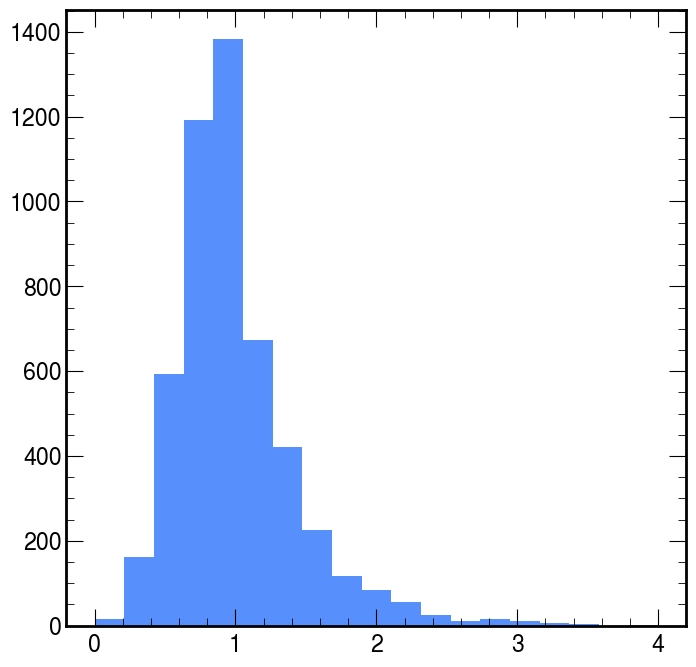

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.hist(
    LP_weights["nom"],
    bins=np.linspace(0,4,20),
)

In [366]:
msk = []
for l in [x.subjet_match for x in LP_weights["reclust_nom"]]:
    if len(l)==2:
        msk.append(True)
    else:
        msk.append(False)
msk = np.array(msk)
len(msk)

14736

In [374]:
(msk!=1).sum()

1150

In [363]:
sub_matching_bool = []
for x in np.array(LP_weights["reclust_nom"])[msk]:
    for y in x.subjet_match:
        sub_matching_bool.append(y)
sub_matching_bool = np.array(sub_matching_bool)
print("sub_matching_bool", sub_matching_bool.shape)

dRs = []
for x in np.array(LP_weights["reclust_nom"])[msk]:
    for y in x.subjet_dRs:
        dRs.append(y)
dRs = np.array(dRs)
print("dRs", dRs.shape)

sub_matching_bool (27172,)
dRs (27172,)


In [369]:
tot = msk.sum()*2
((msk!=1).sum() + len(dRs)) / tot

1.0423229795377595

13586

Text(1, 0, '$\\Delta$R(gen quark,subjet)')

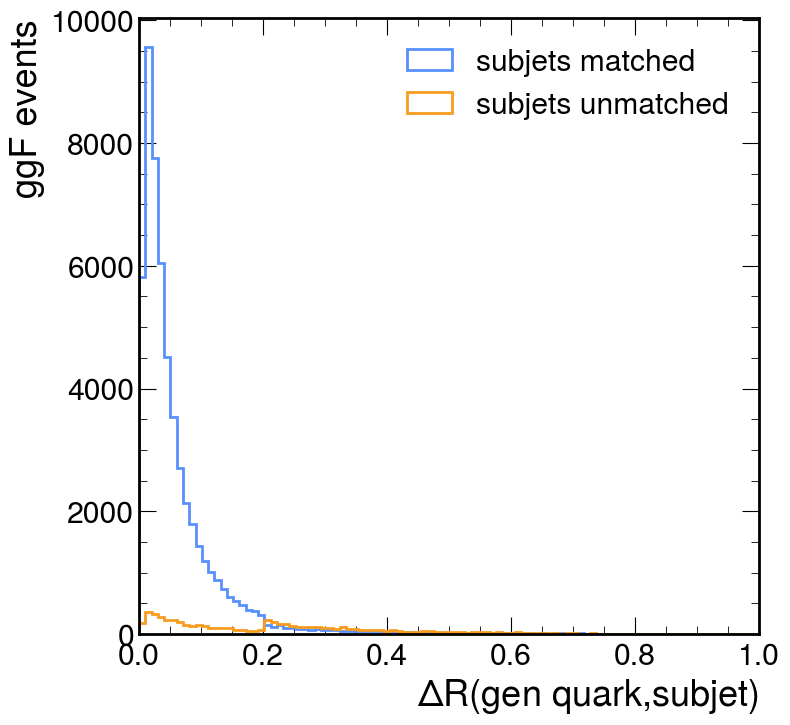

In [338]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist(dRs[sub_matching_bool], bins=np.linspace(0,1,100), histtype="step", lw=2, label="subjets matched")
ax.hist(dRs[~sub_matching_bool], bins=np.linspace(0,1,100), histtype="step", lw=2, label="subjets unmatched")

ax.set_xlim(0,1)
ax.set_ylabel("TTbar events")
ax.legend()
ax.set_xlabel(r"$\Delta$R(gen quark,subjet)")

In [208]:
LP_weights["nom"].shape

(37359,)

In [209]:
LP_weights["nom"]

array([0.73024492, 1.16708584, 0.74874257, ..., 0.87880555, 1.11122473,
       0.64491165])

In [174]:
pd.DataFrame(LP_weights["nom"], columns=["LP_weight"]).to_parquet(f"LP_{ch}_{year}.parquet")

In [211]:
if max_evts == -1:
    score = df["THWW"].values
else:
    score = df["THWW"].values[:max_evts]
score_cut = score > 0.905

###### Use weights to compute efficiency of a cut

#Efficiency of the cut in nominal MC
eff_nom = np.average(score_cut, weights = nom_weights)

#Efficiency of the cut after the Lund Plane reweighting
eff_rw = np.average(score_cut, weights = LP_weights['nom'])

#Nominal 'scale factor'
SF = eff_rw / eff_nom

print("Nominal efficiency %.3f, Corrected efficiency %.3f, SF (corrected / nom) %.3f" % (eff_nom, eff_rw, SF))

#NOTE, because there is kinematic dependence to the correction, it is better to use corrected efficiency computed 
#separately for each MC sample rather than a single 'SF'


######  Compute uncertainties on the efficiency from the various weight variations ##############

#statistical and pt extrapolation uncertainties derived from 100 variations of the weights 
#take std dev to determine unc

nToys = LP_weights['stat_vars'].shape[1]
eff_toys = []
pt_eff_toys = []
for i in range(nToys):
    eff = np.average(score_cut, weights = LP_weights['stat_vars'][:,i])
    eff_toys.append(eff)

    eff1 = np.average(score_cut, weights = LP_weights['pt_vars'][:,i])
    pt_eff_toys.append(eff1)

#Compute stat and pt uncertainty based on variation in the toys
toys_mean = np.mean(eff_toys)
toys_std = np.std(eff_toys)
pt_toys_mean = np.mean(pt_eff_toys)
pt_toys_std = np.std(pt_eff_toys)

#if mean of toys is biased, also include it as an unc (should be zero)
eff_stat_unc = (abs(toys_mean - eff_rw)  + toys_std) 
eff_pt_unc = (abs(pt_toys_mean - eff_rw) + pt_toys_std)

print("Stat variation toys eff. avg %.3f, std dev %.3f" % (toys_mean, toys_std))
print("Pt variation toys eff. avg %.3f, std dev %.3f" % (pt_toys_mean, pt_toys_std))


#Other systematics come from up/down variations of the weights
sys_keys = ['sys', 'bquark', 'prongs', 'unclust', 'distortion']
sys_uncs = dict()

for sys in sys_keys: sys_uncs[sys] = [0.,0.]

#Compute difference in efficiency due to weight variations as uncertainty
def get_uncs(cut, weights_up, weights_down, eff_baseline):
    eff_up =  np.average(cut, weights = weights_up)
    eff_down =  np.average(cut, weights = weights_down)

    unc_up = eff_up - eff_baseline
    unc_down = eff_down - eff_baseline 
    return unc_up, unc_down

for sys in sys_keys:
    unc_up, unc_down = get_uncs(score_cut, LP_weights[sys + '_up'], LP_weights[sys + '_down'], eff_rw)
    sys_uncs[sys] = [unc_up, unc_down]

#Print uncertainty breakdown
eff_str = "Calibrated efficiency  is %.2f +/- %.2f (stat) +/- %.2f (pt)" % (eff_rw, eff_stat_unc, eff_pt_unc )
tot_unc_up = tot_unc_down = eff_stat_unc**2 + eff_pt_unc**2

for sys in sys_keys:
    eff_str += " %.2f/%.2f (%s)" % (sys_uncs[sys][0], sys_uncs[sys][1], sys)
    up_var = max(sys_uncs[sys][0], sys_uncs[sys][1])
    down_var = min(sys_uncs[sys][0], sys_uncs[sys][1])
    tot_unc_up += up_var**2
    tot_unc_down += down_var**2



tot_unc_up = tot_unc_up**0.5
tot_unc_down = tot_unc_down**0.5
print()
#Print final calibrated efficiency and total uncertaintiy
eff_str += "\n Original %.2f, Calibrated %.2f +%.2f/-%.2f \n"  % (eff_nom, eff_rw, tot_unc_up, tot_unc_down)

print(eff_str)
f_ratio.Close()

Nominal efficiency 0.255, Corrected efficiency 0.242, SF (corrected / nom) 0.951
Stat variation toys eff. avg 0.242, std dev 0.005
Pt variation toys eff. avg 0.242, std dev 0.000

Calibrated efficiency  is 0.24 +/- 0.01 (stat) +/- 0.00 (pt) 0.00/0.00 (sys) 0.00/0.00 (bquark) 0.00/-0.01 (prongs) -0.06/0.02 (unclust) 0.00/-0.01 (distortion)
 Original 0.26, Calibrated 0.24 +0.02/-0.06 

